In [30]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

<h2> Dataset & Dataloader

In [31]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [32]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

train_set = datasets.ImageFolder("/content/data/train", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("/content/data/test", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

format picture itu NCHW (n-gambar, channel, height, weight)

In [33]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([128, 1, 28, 28])

In [34]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

<h2> Arsitektur & Config

In [35]:
# membuat 1 layer yang dapat menerima beberapa layer seperti activation, dropout, batch normalization, dan lain-lain
from jcopdl.layers import linear_block

In [36]:
class FashionClassifer(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2): # config -> dynamic hyperparameter
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout), # by default ReLu
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation='lsoftmax')
        )


    def forward(self, x):
        return self.fc(x)

save parameter agar tidak lupa

In [37]:
# save config
config = set_config({
    "input_size": 784,
    "n1": 256,
    "n2": 64,
    "output_size": len(train_set.classes),
    "dropout": 0.2,
})


# keluarkan input size

In [38]:
config

Config(dropout=0.2, input_size=784, n1=256, n2=64, output_size=10)

<h2> Training Preparation -> MCOC (Model, Criterion, Optimizer, Callback)

In [39]:
model = FashionClassifer(config.input_size,
                         config.n1,
                         config.n2,
                         config.output_size,
                         config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.003)
callback = Callback(model, config, outdir="model")

In [40]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [52]:


weights = torch.load("/content/model/weights_best.pth", map_location="cpu")
config = torch.load("/content/model/configs.pth", map_location="cpu")


model = FashionClassifer(config.input_size,
                         config.n1,
                         config.n2,
                         config.output_size,
                         config.dropout).to(device)

model.load_state_dict(weights)
model = model.to(device)

In [53]:
model

FashionClassifer(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=784, out_features=256, bias=True)
        (relu): ReLU()
        (do): Dropout(p=0.2, inplace=False)
      )
    )
    (2): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=256, out_features=64, bias=True)
        (relu): ReLU()
        (do): Dropout(p=0.2, inplace=False)
      )
    )
    (3): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=64, out_features=10, bias=True)
        (lsoftmax): LogSoftmax(dim=1)
      )
    )
  )
)

<h2> Predict

In [54]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [55]:
with torch.no_grad():
  model.eval()
  output = model(feature) # prob
  preds = output.argmax(1) # pick paling gedhe

[label2cat[pred] for pred in preds]


['T-shirt or Top',
 'Sneaker',
 'Dress',
 'Coat',
 'T-shirt or Top',
 'Sneaker',
 'Sandal',
 'Pullover',
 'Dress',
 'Sneaker',
 'Shirt',
 'Bag',
 'Sneaker',
 'Sandal',
 'Sneaker',
 'Shirt',
 'Bag',
 'Sandal',
 'Shirt',
 'Coat',
 'Coat',
 'Shirt',
 'Pullover',
 'Pullover',
 'Bag',
 'Trouser',
 'Sandal',
 'Bag',
 'Pullover',
 'T-shirt or Top',
 'Ankle boot',
 'Sneaker',
 'Bag',
 'Bag',
 'T-shirt or Top',
 'Bag',
 'Dress',
 'Coat',
 'Shirt',
 'Sneaker',
 'Pullover',
 'Sneaker',
 'Ankle boot',
 'T-shirt or Top',
 'T-shirt or Top',
 'T-shirt or Top',
 'Bag',
 'Sneaker',
 'Sandal',
 'Coat',
 'Ankle boot',
 'Shirt',
 'Shirt',
 'Shirt',
 'Trouser',
 'Bag',
 'Pullover',
 'Coat',
 'Bag',
 'T-shirt or Top',
 'Ankle boot',
 'Sandal',
 'Dress',
 'Sneaker',
 'T-shirt or Top',
 'T-shirt or Top',
 'Sneaker',
 'Sandal',
 'Trouser',
 'Ankle boot',
 'Pullover',
 'Sneaker',
 'Sandal',
 'Sneaker',
 'Pullover',
 'Sneaker',
 'Trouser',
 'Bag',
 'Bag',
 'Ankle boot',
 'Ankle boot',
 'Sneaker',
 'Trouser',
 'S

Visualisasi

In [50]:
import matplotlib.pyplot as plt

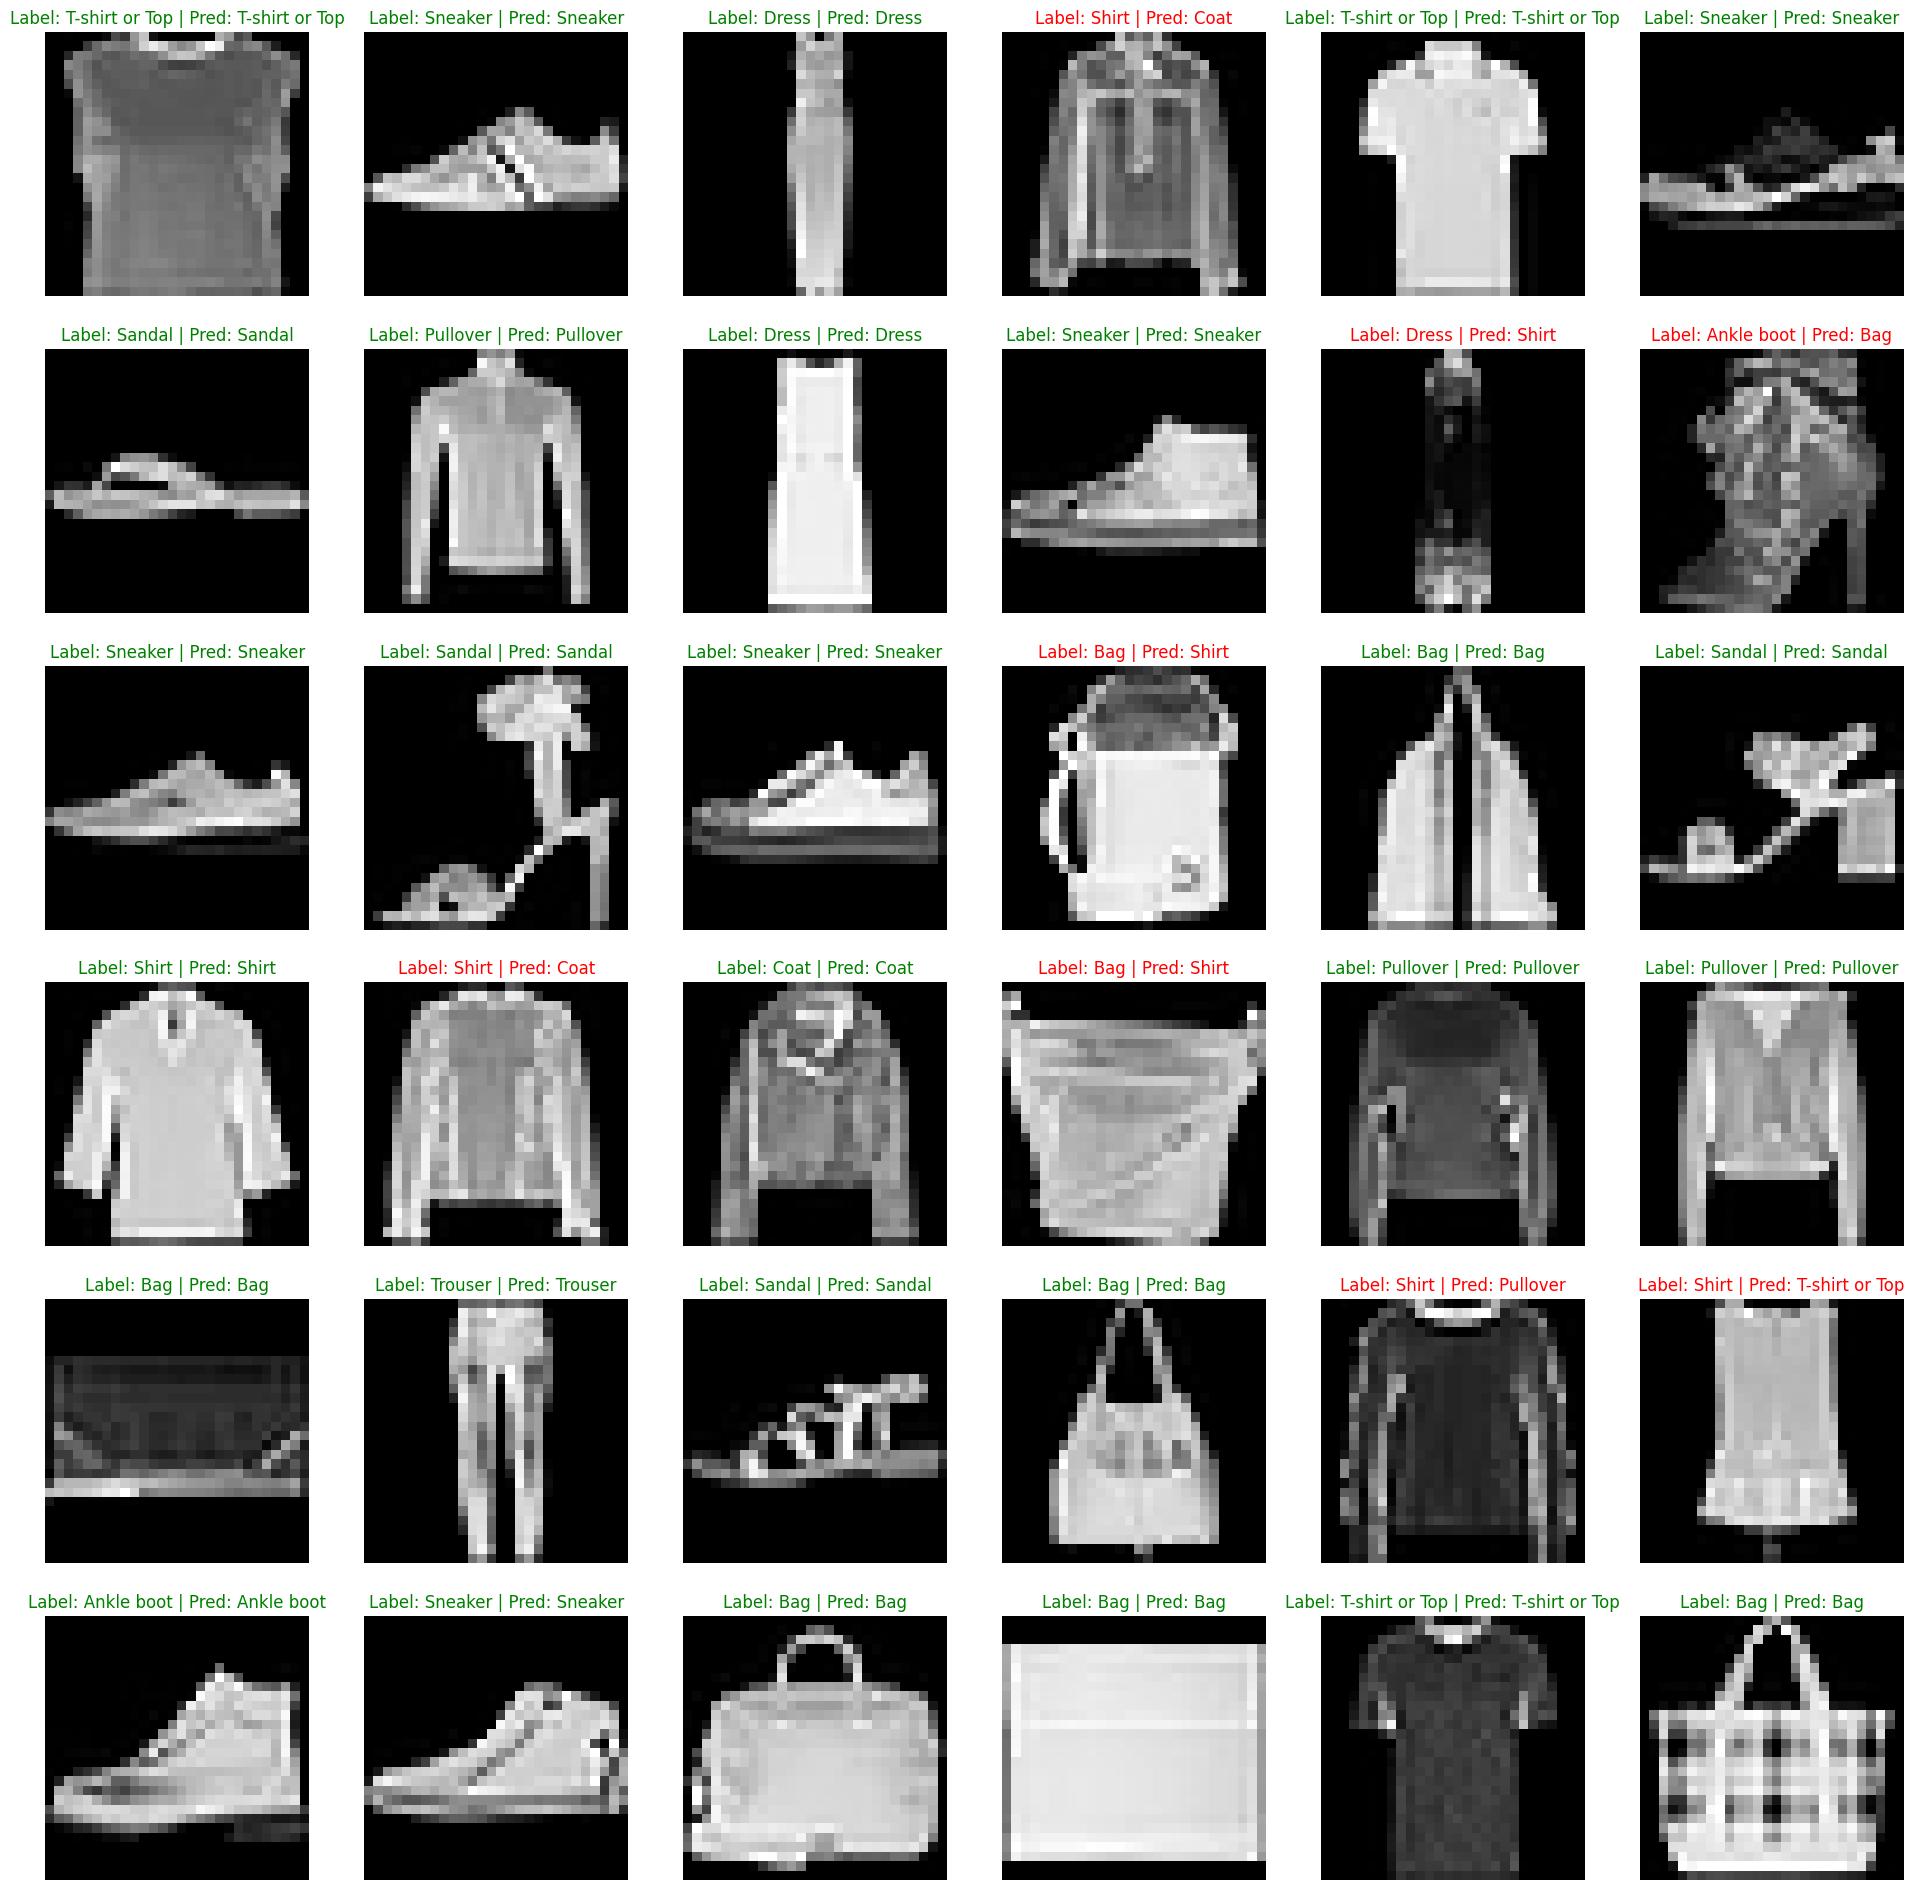

In [57]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.view(28,28).cpu(), cmap='gray')
  font = {"color": 'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
  ax.axis('off');